# Bank marketing and Term Deposit Prediction

Lien Kaggle : https://archive.ics.uci.edu/dataset/222/bank+marketing


About data

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

Author :
ATJI Cheick

## Libraries loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from scipy.stats import (pointbiserialr, chi2_contingency)
import statsmodels.api as sm


from xgboost import XGBClassifier


from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)

from sklearn.metrics import (f1_score, precision_score, recall_score, confusion_matrix,
                            accuracy_score, roc_auc_score, roc_curve, classification_report,
                            auc, ConfusionMatrixDisplay, RocCurveDisplay, get_scorer_names)

from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold,
                                     cross_val_score,
                                     learning_curve)



from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import (RandomUnderSampler, TomekLinks, NearMiss)

import warnings

import random

warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',100)
random.seed(123)

## data loading

In [2]:
#description type de variables
dictionnaire = {'age':'Age',
                'job':'Type of job, ex: entrepreneur',
                'marital':'Marital status, ex: divorced',
                'education':'education level, ex: high-school',
                'default':'Has credit in default? yes or no',
                'balance':'average yearly balance, ex: 24,000 USD',
                'housing':'has housing loan? yes or no',
                'loan':'has personal loan? yes or no',
                'contact':'cellular or telephone',
                'day':'last contact day of the month',
                'month':'last contact month of the year',
                'duration':'last contact duration in seconds',
                'campaign':'number of contacts performed during this campaign and for this client (numeric, includes last contact)',
                'pdays':'number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)',
                'previous':'number of contacts performed before this campaign and for this client (numeric)',
                'poutcome':'outcome of the previous marketing campaign (categorical: unknown, other,failure,success)',
                'y':'has the client subscribed a term deposit? (binary: yes or no)'
                }


def info(data):

    Information = pd.DataFrame({
        'Variables': data.columns,
        'Type': data.dtypes,
        'Unique_values': data.nunique(),
        'NA_counts': data.isna().sum(),
        'NA_percent%':data.isna().mean().round(4)*100,
        }).reset_index(drop=True)

    Information['Description_des_variables'] = Information['Variables'].map(dictionnaire)
    
    return Information

In [3]:
data = pd.read_csv('data/bank.csv', sep=';')

## fonction pour caster les variables

In [4]:


def conversion(var):

    # conversion des variables type = <objet>
    if (var.dtype == 'object'):
        try:
            
            # conversion en string
            if var.nunique() > 12:
                return var.astype(str)
            
            # conversion en catégorie 
            else:
                return var.astype('category')
        
        except ValueError:
            
            return var
    
    else:
        return var 


In [5]:
data = data.apply(conversion)

In [6]:
info(data)

,Variables,Type,Unique_values,NA_counts,NA_percent%,Description_des_variables
0,age,int64,67,0,0.0,Age
1,job,category,12,0,0.0,"Type of job, ex: entrepreneur"
2,marital,category,3,0,0.0,"Marital status, ex: divorced"
3,education,category,4,0,0.0,"education level, ex: high-school"
4,default,category,2,0,0.0,Has credit in default? yes or no
5,balance,int64,2353,0,0.0,"average yearly balance, ex: 24,000 USD"
6,housing,category,2,0,0.0,has housing loan? yes or no
7,loan,category,2,0,0.0,has personal loan? yes or no
8,contact,category,3,0,0.0,cellular or telephone
9,day,int64,31,0,0.0,last contact day of the month


- Lister les variables catégorielles et les variables numériques

In [7]:
#Renommer la variable y
data.rename(columns={"y": "credit_subscribed"}, inplace=True)

# liste variables numériques
numvars = data.select_dtypes(exclude=['category']).columns.tolist()

#liste variables catégorielles
catvars = data.select_dtypes(include=['category']).columns.tolist()

## Visualisation des données 

#### Récodage de certaines  variables

In [8]:
data['job'] = data['job'].replace(['unemployed', 'self-employed', 'student', 'services', 
                                   'housemaid', 'retired','entrepreneur', 'unknown'], 'others')

data['poutcome'] = data['poutcome'].replace('other','success')

data['education'] = data['education'].replace('unknown','primary')

In [9]:

def category_distribution(data, var):
    # Validation des données
    if not isinstance(data, pd.DataFrame):
        raise TypeError('data is not a pandas.DataFrame')

    if var not in data.columns or data[var].dtype != 'category':
        raise TypeError(f'{var} not in data or not a <dtype.category>')
    
    # Calcul des fréquences et des pourcentages
    counts = data[var].value_counts()
    percentages = data[var].value_counts(normalize=True) * 100

    # Création du tableau
    distribution_table = pd.DataFrame({
        'Nombre d\'observations': counts,
        'Pourcentage (%)': percentages.round(2)
    })
        # Calcul des totaux
    total_counts = counts.sum()
    total_percentage = percentages.sum()

    # Ajout de la ligne des totaux
    distribution_table.loc['Total'] = [total_counts, total_percentage]
    
    print(f"Repartition des effectifs: {var}")
    
    return distribution_table


In [10]:
# repartition de la variable d'intérêt
category_distribution(data, 'credit_subscribed')

Repartition des effectifs: credit_subscribed


,Nombre d'observations,Pourcentage (%)
credit_subscribed,,
no,4000.0,88.48
yes,521.0,11.52
Total,4521.0,100.00


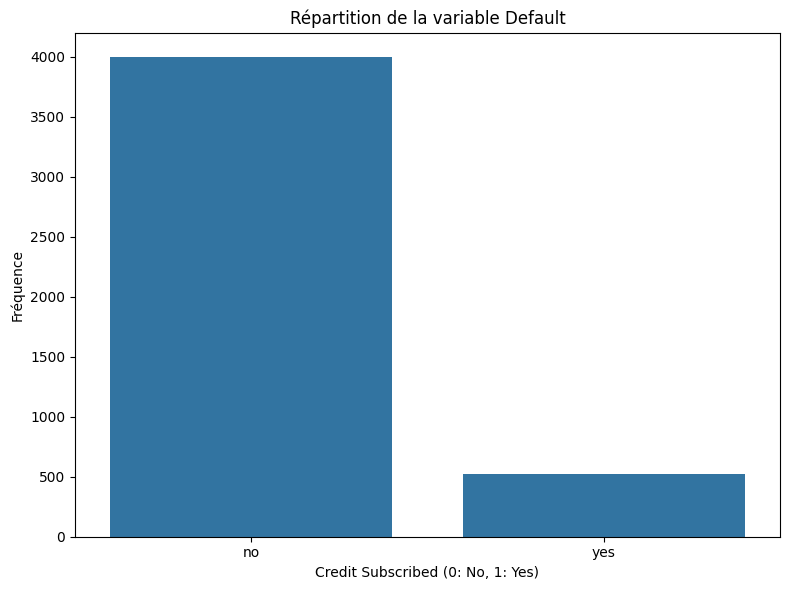

In [11]:
# Visualiser la répartition
plt.figure(figsize=(8, 6))
sns.countplot(x='credit_subscribed', data = data)
plt.title('Répartition de la variable Default')
plt.xlabel('Credit Subscribed (0: No, 1: Yes)')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

In [12]:
def plot_categorical_distribution(df, target, features, n_cols=3):
    """
    Affiche la répartition de la variable cible en fonction d'une liste de variables catégorielles
    en utilisant seaborn.countplot.
    
    Paramètres
    ----------
    df : pandas.DataFrame
        Jeu de données.
    target : str
        Nom de la variable catégorielle cible.
    features : list of str
        Liste des variables catégorielles explicatives.
    n_cols : int
        Nombre de colonnes dans la grille d'affichage.
    """
    n_features = len(features)
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=False)

    axes = axes.flatten()

    for ax, feature in zip(axes, features):
        sns.countplot(data=df, x=feature, hue=target, ax=ax)
        ax.set_title(f"Répartition de {target}\nselon {feature}")
        ax.set_ylabel("Nombre d'observations")
        ax.tick_params(axis='x', rotation=45)  # rotation si labels trop longs

    # Supprimer les axes vides si nb variables < n_rows * n_cols
    for ax in axes[n_features:]:
        ax.remove()

    plt.tight_layout()
    plt.show()


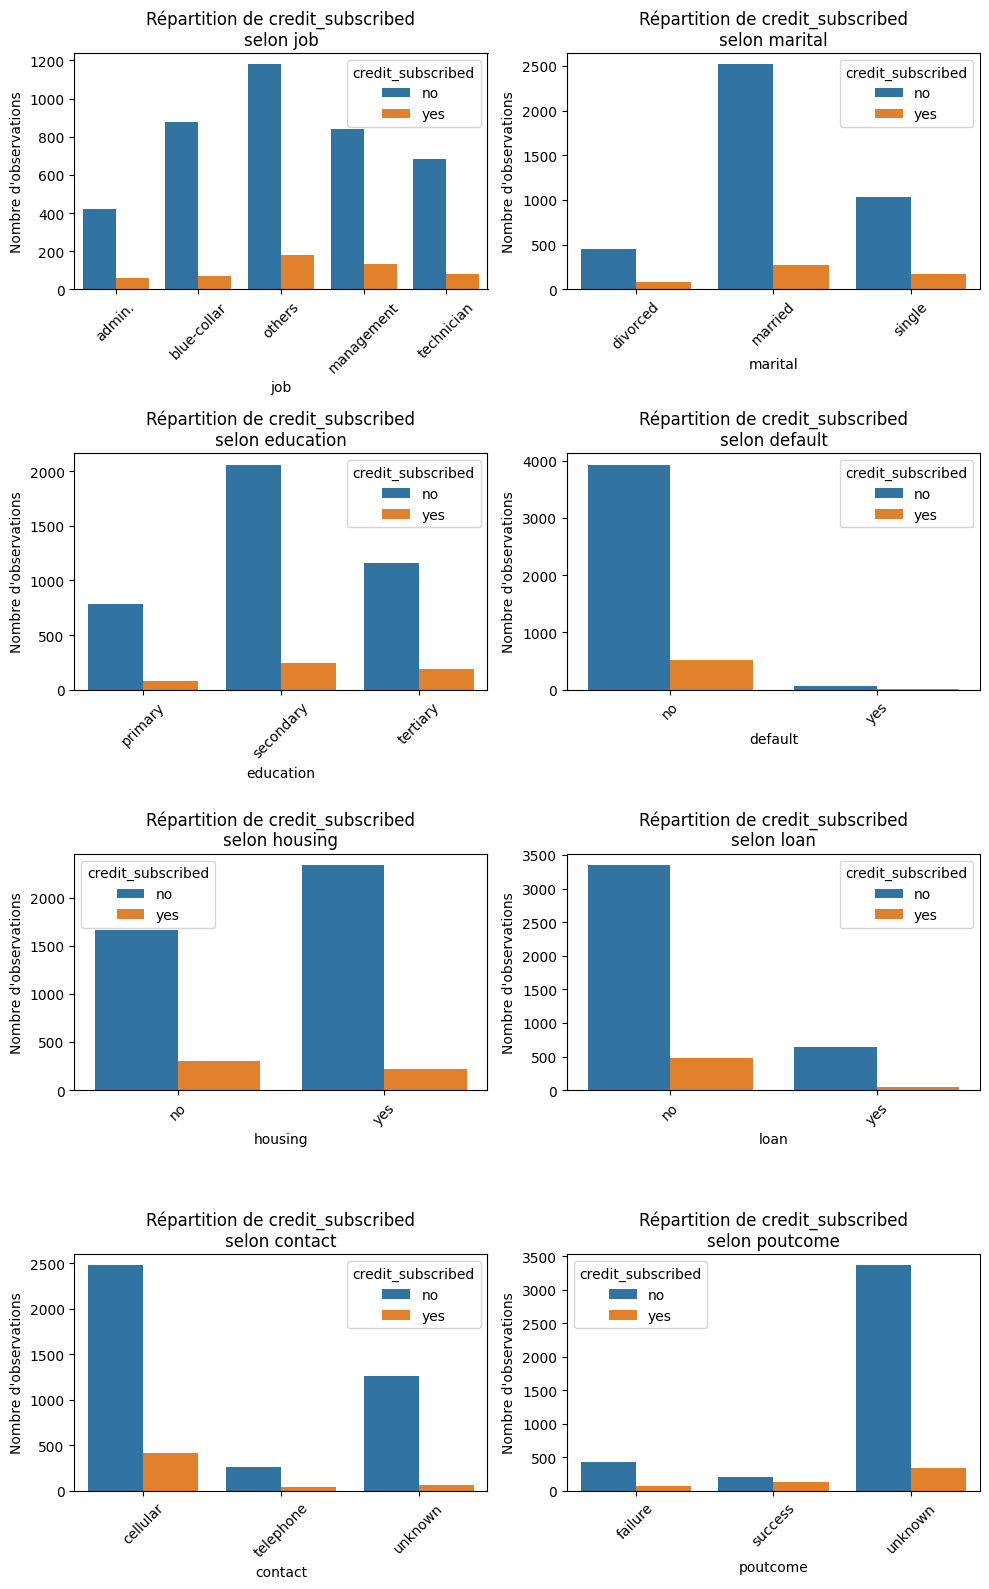

In [13]:
maliste = [x for x in catvars if x not in ['credit_subscribed', 'month']]
plot_categorical_distribution(data, 'credit_subscribed', maliste, n_cols=2)

### Visualisations croisées entre la variable d'intérêt et les variables continues

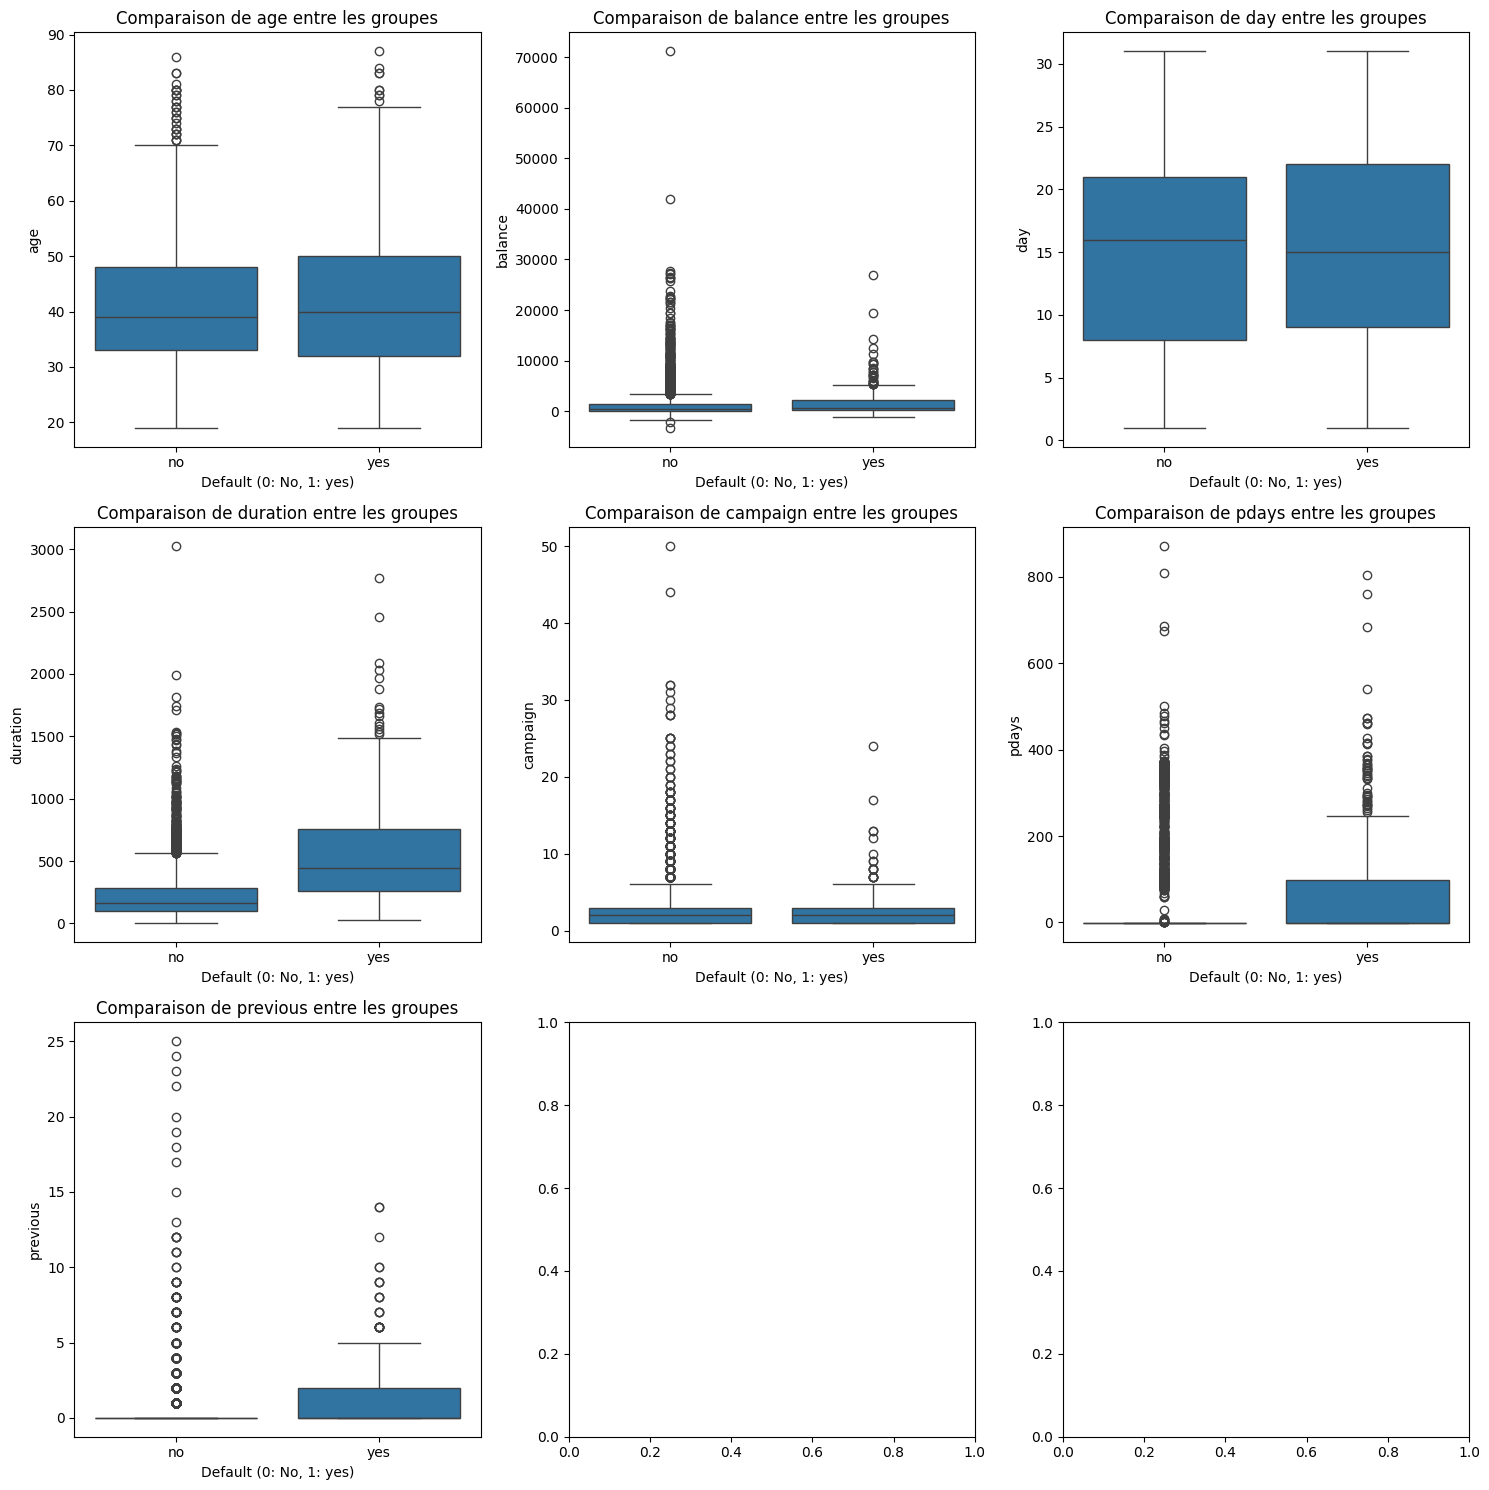

In [14]:

# Calcul du nombre de lignes et de colonnes pour la grille
n_vars = len(numvars)
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

# Création de la grille de sous-graphiques
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows)) # Ajuster la taille si besoin

# Affichage des box plots dans les sous-graphiques
for i, variable in enumerate(numvars):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(x='credit_subscribed', y=variable, data=data, ax=axes[row, col])
    axes[row, col].set_title(f'Comparaison de {variable} entre les groupes')
    axes[row, col].set_xlabel('Default (0: No, 1: yes)')
    axes[row, col].set_ylabel(variable)

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage de la grille de sous-graphiques
plt.show()

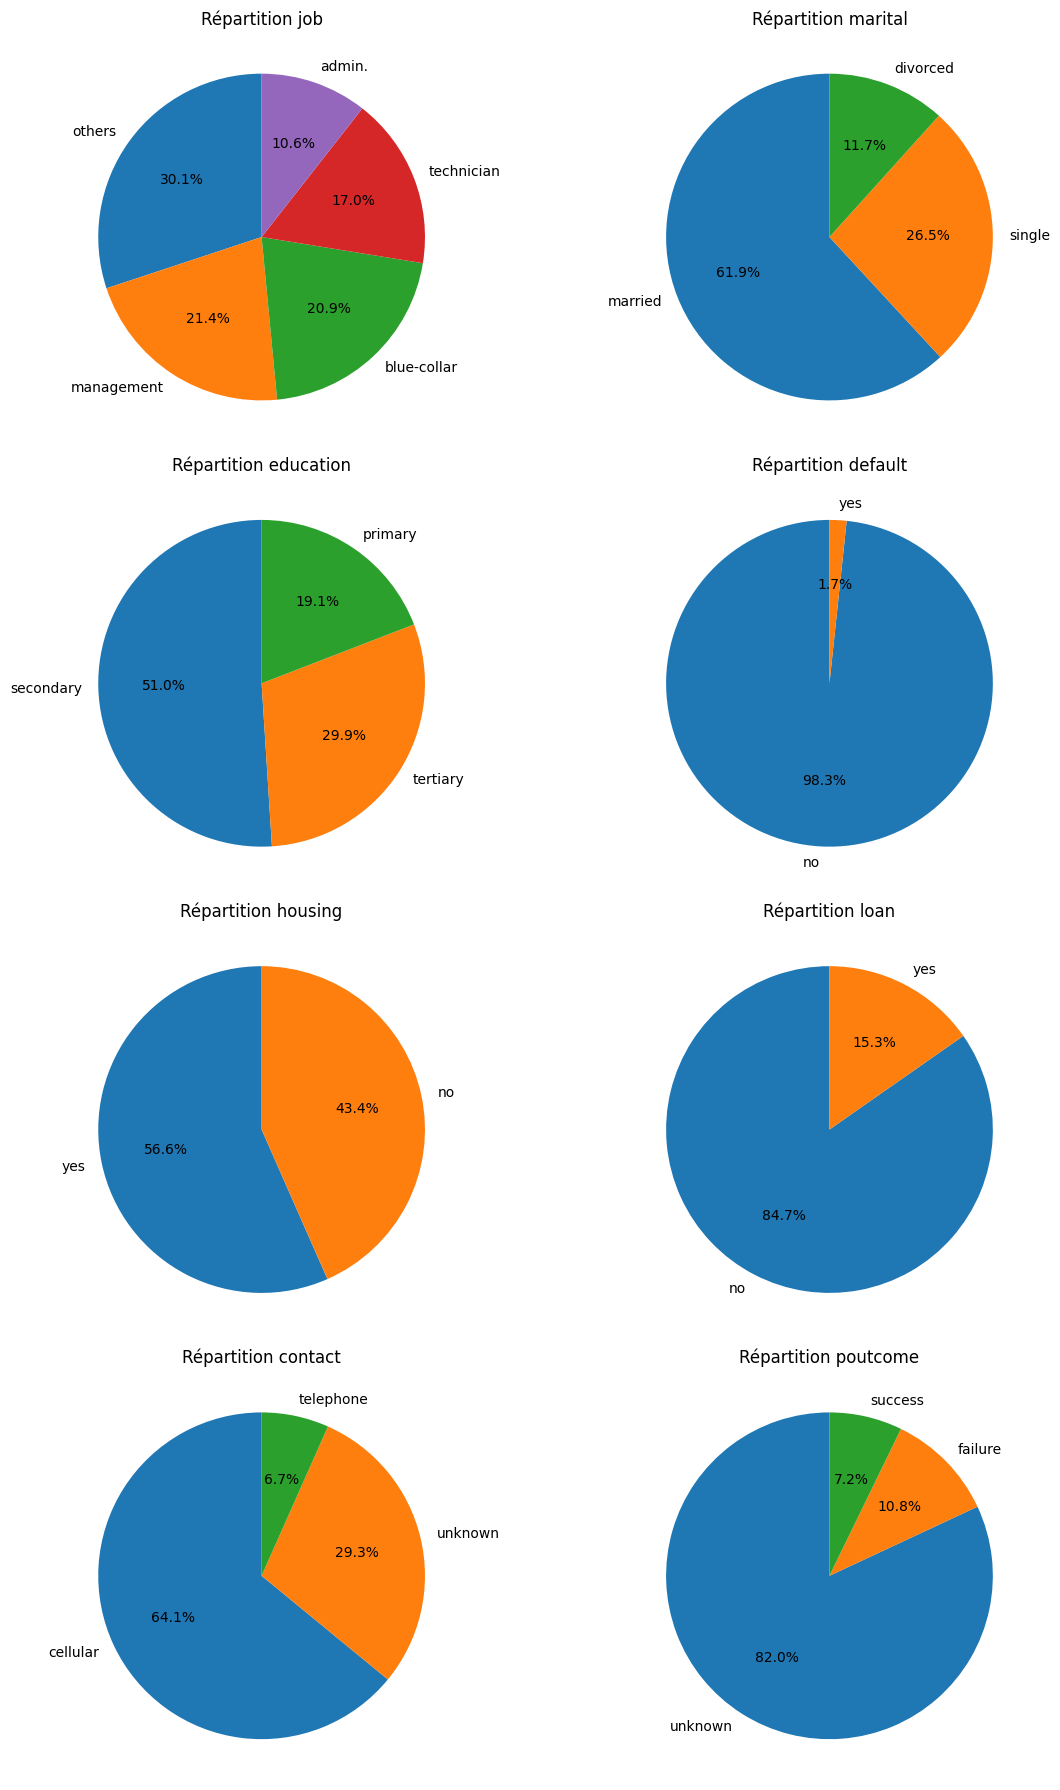

In [15]:
# Création de la figure avec 2 lignes et 6 colonnes
fig, axes = plt.subplots(4, 2, figsize=(12, 18))

# Liste des colonnes à afficher
columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
           'poutcome']

# Boucle pour créer les graphiques
for i, col in enumerate(columns):
    row = i // 2
    col_index = i % 2

    data[col].value_counts().plot.pie(ax=axes[row, col_index], autopct='%1.1f%%', startangle=90)
    axes[row, col_index].set_title(f"Répartition {col}")
    axes[row, col_index].set_ylabel("")


plt.tight_layout()
plt.show()

## Analyses Statistiques 

### Corrélation entre les variables

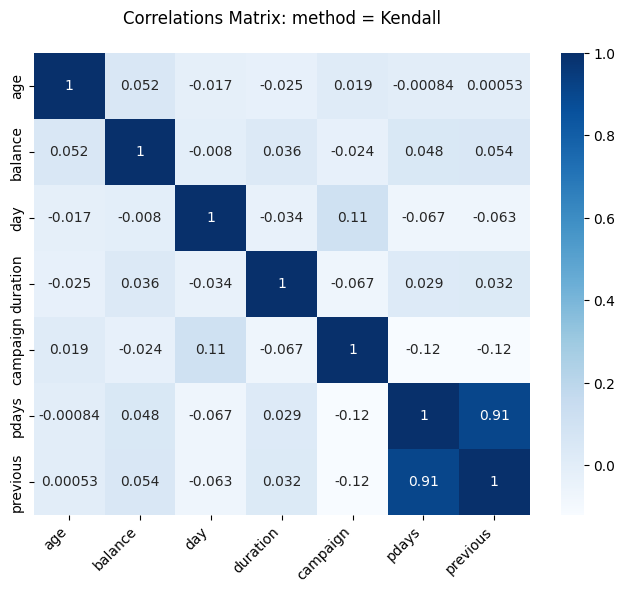

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(data[numvars].corr(method='kendall'),
            cmap='Blues', annot=True)
plt.title('Correlations Matrix: method = Kendall\n')
plt.xticks(rotation=45, ha='right')
plt.show()

### Tableau statistiques croisés sur solde de crédit  

In [17]:
def cross_stat(data:pd.DataFrame, catlist:list, statvars:list):

    """--Docstring--
    fonction pour réaliser des statistiques
    sur des variables croisées.
    
    Args:
         data: le dataframe
         catlist: (list) variables catégorielles
         statvars: (list) variables continues
    
    return a dataframe
    """
    # initialisation d'un tableau vide
    table = pd.DataFrame()
    
    # Création de dictionnaire pour les indexes
    index_mapping = {value: cat for cat in catlist for value in data[cat].unique()}

    
    for var in statvars:

        for cat in catlist:
            
            X = data.groupby(by=cat)[var].agg(min = 'min',
                                              max = 'max',
                                              mean = 'mean',
                                              st_deviation = 'std',
                                              quartile1 = lambda x: x.quantile(0.25),
                                              median = 'median',
                                              quartile3 = lambda x: x.quantile(0.75),
                                              category_size = 'count')

            table = pd.concat([table,X], axis = 0, ignore_index = False)
    
        table.reset_index(names = 'valeurs', inplace = True)
        table['Categories'] = table['valeurs'].map(index_mapping)
        table.set_index(['Categories','valeurs'], inplace = True)
    
        print(f'Tableau Statistiques croisées sur: {var}')
        display(table.round(2))
        print('\n\n')


In [18]:
cross_stat(data, catvars, ['balance'])

Tableau Statistiques croisées sur: balance


min    max     mean  st_deviation  quartile1  \
Categories        valeurs                                                      
job               admin.       -967  22171  1226.74       2370.12      62.25   
                  blue-collar -1400  16353  1085.16       2040.22      61.00   
                  others      -3313  71188  1532.75       3681.80      64.00   
                  management  -1746  27359  1766.93       3267.73      99.00   
                  technician  -1680  27733  1331.00       2630.25      64.00   
marital           divorced    -1148  26306  1122.39       2199.92      31.25   
                  married     -3313  71188  1463.20       3188.57      72.00   
                  single      -1313  27733  1460.41       2879.81      81.00   
education         primary      -966  71188  1474.17       3568.57      71.00   
                  secondary   -2082  26452  1196.81       2419.70      57.00   
                  tertiary    -3313  42045  1775.42       3460.62     102.00   
credit_subscribed no          -1746  71188  1450.55       3026.70      81.00   
                  yes         -3313   1238  -208.72        575.68    -327.50   
                  no          -2082  71188  1595.28       3440.85      64.00   
                  yes         -3313  27733  1290.31       2624.64      74.50   
                  no          -1746  71188  1513.86       3121.23      81.25   
                  yes         -3313  27069   917.16       2229.89       8.50   
contact           cellular    -2082  71188  1423.20       3058.21      64.00   
                  telephone   -1400  26452  1806.04       3250.22     145.00   
poutcome          unknown     -3313  27733  1334.32       2836.18      69.75   
month             apr          -932  26965  1658.06       3045.67     243.00   
                  aug          -970  42045  1454.56       3152.32      51.00   
                  dec           389  14533  3567.15       4448.25     914.50   
                  feb          -970  26306  1319.04       2421.58     156.00   
                  jan          -735  16957   976.36       1911.02      76.75   
                  jul         -2082  26452   789.47       1980.83       0.00   
                  jun         -1746  27733  1884.79       3600.50     144.50   
                  mar             0   9676  2049.53       2584.93     273.00   
                  may         -3313  22546  1104.17       2346.05      60.00   
                  nov          -872  22196  2603.15       3514.00     246.00   
                  oct          -247  71188  2738.65       8369.52     195.00   
                  sep          -195  14220  1589.35       2773.45      39.75   
poutcome          failure     -1400  26306  1644.65       3252.29     139.75   
                  success      -247  15459  1632.19       2599.91     142.75   
                  unknown     -3313  71188  1374.86       3008.52      60.00   
credit_subscribed no          -3313  71188  1403.21       3075.35      61.00   
                  yes         -1206  26965  1571.96       2444.40     171.00   

                               median  quartile3  category_size  
Categories        valeurs                                        
job               admin.        430.0    1320.75            478  
                  blue-collar   408.5    1204.50            946  
                  others        411.5    1535.00           1360  
                  management    577.0    1859.00            969  
                  technician    434.5    1412.25            768  
marital           divorced      367.5    1245.00            528  
                  married       452.0    1521.00           2797  
                  single        462.0    1509.00           1196  
education         primary       429.0    1550.00            865  
                  secondary     385.5    1269.75           2306  
                  tertiary      583.5    1840.00           1350  
credit_subscribed no            462.0    1517.00     

### Test d'associations du khi-deux entre les variables catégorielles et la variable cible 

In [19]:

def test_khi2(data, target, variables, alpha=0.05):
    """
    Calcule les tests du Chi2 entre une liste de variables catégorielles et une variable cible binaire.

    Parameters:
        data (pd.DataFrame): le DataFrame contenant les données
        target (str): nom de la variable cible (ex: "Default")
        variables (list): liste des variables catégorielles
        alpha (float): seuil de significativité (par défaut 0.05)

    Returns:
        pd.DataFrame: tableau récapitulatif des résultats
    """
    results = []

    for var in variables:
        contingency_table = pd.crosstab(data[var], data[target])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        decision = "Rejeter H0 (association)" if p < alpha else "Ne pas rejeter H0 (indépendance)"
        results.append({
            "Variable": var,
            "Chi2": chi2,
            "ddl": dof,
            "p-value": p,
            "Décision (alpha={})".format(alpha): decision
                        })

    return pd.DataFrame(results)



- Application du test

In [20]:
liste = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

test_khi2(data, target = "credit_subscribed", variables = liste)

,Variable,Chi2,ddl,p-value,Décision (alpha=0.05)
0,job,24.852780,4,5.385756e-05,Rejeter H0 (association)
1,marital,19.030056,2,7.373535e-05,Rejeter H0 (association)
2,education,15.161870,2,5.100841e-04,Rejeter H0 (association)
3,default,0.000000,1,1.000000e+00,Ne pas rejeter H0 (indépendance)
4,housing,48.884628,1,2.714700e-12,Rejeter H0 (association)
5,loan,21.871822,1,2.914829e-06,Rejeter H0 (association)
6,contact,87.869857,2,8.304301e-20,Rejeter H0 (association)
7,poutcome,231.698414,2,4.867754e-51,Rejeter H0 (association)


### Test de corrélation Pearson entre la variable d'intérêt et les variables continues

In [21]:
def corr_pearson(data, target, variables, alpha=0.05):
    """
    Calcule la corrélation point-bisérial entre une variable binaire et plusieurs variables continues.

    Parameters:
        data (pd.DataFrame): DataFrame contenant les données
        target (str): nom de la variable binaire (ex: "Default")
        variables (list): liste des variables continues
        alpha (float): seuil de significativité (par défaut 0.05)

    Returns:
        pd.DataFrame: tableau récapitulatif avec corrélation, p-value et décision
    """
    results = []

  
    a, b = data[target].unique()
    y = data[target].map({a:0, b:1}).astype('float')

    for var in variables:
        x = data[var]

        # Calcul corrélation point-bisérial
        corr, pval = pointbiserialr(y, x)

        decision = "Rejeter H0 (association)" if pval < alpha else "Ne pas rejeter H0 (indépendance)"
        results.append({
            "Variable": var,
            "Corrélation (r_pb)": corr,
            "p-value": pval,
            "Décision (alpha={})".format(alpha): decision
        })

    return pd.DataFrame(results)


- Application du test de correlation

In [22]:
corr_pearson(data, target = "credit_subscribed", variables = numvars)

,Variable,Corrélation (r_pb),p-value,Décision (alpha=0.05)
0,age,0.045092,2.424536e-03,Rejeter H0 (association)
1,balance,0.017905,2.287158e-01,Ne pas rejeter H0 (indépendance)
2,day,-0.011244,4.497348e-01,Ne pas rejeter H0 (indépendance)
3,duration,0.401118,2.150445e-174,Rejeter H0 (association)
4,campaign,-0.061147,3.885794e-05,Rejeter H0 (association)
5,pdays,0.104087,2.287071e-12,Rejeter H0 (association)
6,previous,0.116714,3.477971e-15,Rejeter H0 (association)


## Modélisation du Score

### Modèles Statistiques standart

- Préparation des données

In [23]:
# Variable d'intérêt
y = data['credit_subscribed'].map({'yes':1,'no':0}).astype('int')

# Variables explicatives
quantvars = [x for x in numvars if x not in ['duration', 'previous', 'balance', 'day', 'pdays']]
categvars =  [x for x in catvars if x not in ['education','marital','job', 'month', 'contact','credit_subscribed', 'default']]
variables = quantvars + categvars

# Matrices des regresseurs
X = pd.get_dummies(data[variables],
                   columns=categvars,
                   drop_first=True).astype(int)

X_cst = sm.add_constant(X, prepend=False)

#### Regression logistique

In [24]:
model_logistic = sm.Logit(y,X_cst)
results = model_logistic.fit(methode = 'newton')
results.summary2()

Optimization terminated successfully.
         Current function value: 0.329588
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit             Method:           MLE       
Dependent Variable: credit_subscribed Pseudo R-squared: 0.078     
Date:               2025-09-25 13:41  AIC:              2994.1371 
No. Observations:   4521              BIC:              3039.0525 
Df Model:           6                 Log-Likelihood:   -1490.1   
Df Residuals:       4514              LL-Null:          -1615.5   
Converged:          1.0000            LLR p-value:      2.6821e-51
No. Iterations:     7.0000            Scale:            1.0000    
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
age                 0.0061   0.0043  1.4032 0.1606 -0.0024  0.0146
campaign           -0.0770   0.0237 -3.2529 0.0011 -0.1233 -0.0306
housing_yes        -0.6576   0.0997 -6.5955 0.0000 -0.8530 -0.4622
loan_yes           -0.6523   0.1676 -3.8914 0.0001 -0.9808 -0.3237
poutcome_success    1.2942   0.1802  7.1800 0.0000  0.9409  1.6475
poutcome_unknown   -0.4163   0.1499 -2.7772 0.0055 -0.7101 -0.1225
const              -1.5315   0.2507 -6.1096 0.0000 -2.0228 -1.0402
==================================================================

"""

#### Les modèles GLM: 

##### Binomial family

In [25]:
binomial = sm.families.Binomial()
model_glm = sm.GLM(y, X_cst, family = binomial)
results = model_glm.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM               AIC:            2994.1371  
Link Function:      Logit             BIC:            -35011.8919
Dependent Variable: credit_subscribed Log-Likelihood: -1490.1    
Date:               2025-09-25 13:41  LL-Null:        -1615.5    
No. Observations:   4521              Deviance:       2980.1     
Df Model:           6                 Pearson chi2:   4.67e+03   
Df Residuals:       4514              Scale:          1.0000     
Method:             IRLS                                         
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age                0.0061   0.0043  1.4032 0.1606 -0.0024  0.0146
campaign          -0.0770   0.0237 -3.2529 0.0011 -0.1233 -0.0306
housing_yes       -0.6576   0.0997 -6.5955 0.0000 -0.8530 -0.4622
loan_yes          -0.6523   0.1676 -3.8914 0.0001 -0.9808 -0.3237
poutcome_success   1.2942   0.1802  7.1800 0.0000  0.9409  1.6475
poutcome_unknown  -0.4163   0.1499 -2.7772 0.0055 -0.7101 -0.1225
const             -1.5315   0.2507 -6.1096 0.0000 -2.0228 -1.0402
=================================================================

"""

##### complementary log-Log (Clog-log) family

In [26]:
# Complementary log-log
cloglog = sm.families.Binomial(link=sm.families.links.cloglog())
model_cloglog = sm.GLM(y, X_cst, family = cloglog)
results = model_cloglog.fit()
results.summary2()
#np.exp(results.params)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM               AIC:            2991.6433  
Link Function:      cloglog           BIC:            -35014.3857
Dependent Variable: credit_subscribed Log-Likelihood: -1488.8    
Date:               2025-09-25 13:41  LL-Null:        -1615.5    
No. Observations:   4521              Deviance:       2977.6     
Df Model:           6                 Pearson chi2:   4.65e+03   
Df Residuals:       4514              Scale:          1.0000     
Method:             IRLS                                         
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age                0.0054   0.0038  1.4175 0.1563 -0.0021  0.0130
campaign          -0.0736   0.0224 -3.2836 0.0010 -0.1175 -0.0297
housing_yes       -0.6169   0.0912 -6.7607 0.0000 -0.7957 -0.4380
loan_yes          -0.6106   0.1598 -3.8215 0.0001 -0.9238 -0.2975
poutcome_success   1.1209   0.1567  7.1513 0.0000  0.8137  1.4282
poutcome_unknown  -0.3903   0.1390 -2.8082 0.0050 -0.6628 -0.1179
const             -1.6153   0.2259 -7.1519 0.0000 -2.0580 -1.1727
=================================================================

"""

### Machine Learning

#### Decoupage des données en train/test 

- selection des variables (features)

In [69]:
X_cats = ['job', 'marital', 'education','housing', 'loan','poutcome', 'contact']
X_nums = ['age', 'balance', 'day', 'duration', 'campaign', 'previous']

In [70]:
#Séparer les données en features (X) et target (y)
data_sorted = data.sort_values(by='balance', ignore_index=True)
features = data_sorted[X_cats + X_nums]
target = data_sorted["credit_subscribed"].map({'no':0, 'yes':1}).astype('int')

#Diviser les données en train et test

X_train, X_test, y_train, y_test = train_test_split(
                                                    features, target, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle = True, 
                                                    stratify=target
                                                    )

print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))

Taille de l'ensemble d'entraînement : 3616
Taille de l'ensemble de test : 905


- Surechantillonnage du train set par la methode SMOTENC

In [71]:
# Déterminer l'indice des colonnes catégorielles dans le trainset 
position = [X_train.columns.get_loc(x) for x in X_cats]

# Création de l'instance SMOTE
smote = SMOTENC(categorical_features=position, random_state=42)

# Réechantillonnage (fitting)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

- Sousechantillonnage du train set 

In [82]:
rd_sampling = RandomUnderSampler(random_state=42) # reduce majority class
tk_sampling = TomekLinks() # removing noises from dataset
nm_sampling = NearMiss(n_neighbors=5) # intelligent Selecting

X = pd.get_dummies(X_train, columns = X_cats, drop_first=True)

X_sampled, y_sampled = nm_sampling.fit_resample(X, y_train)

# Retrouver les colonnes d'origine
X_train.sort_values(by='balance', inplace = True, ignore_index=True)
X_sampled.sort_values(by = 'balance', inplace = True, ignore_index=True)
merged = pd.merge(X_sampled, X_train, left_index=True, right_index=True, how="inner")
merged.rename(columns=lambda x: x[:-2] if x.endswith("_y") else x, inplace = True)
X_sampled = merged[X_cats + X_nums]

print(f"{X_sampled.shape}\n\n{y_sampled.value_counts()}")

(834, 13)

credit_subscribed
0    417
1    417
Name: count, dtype: int64


- Affichage des sets

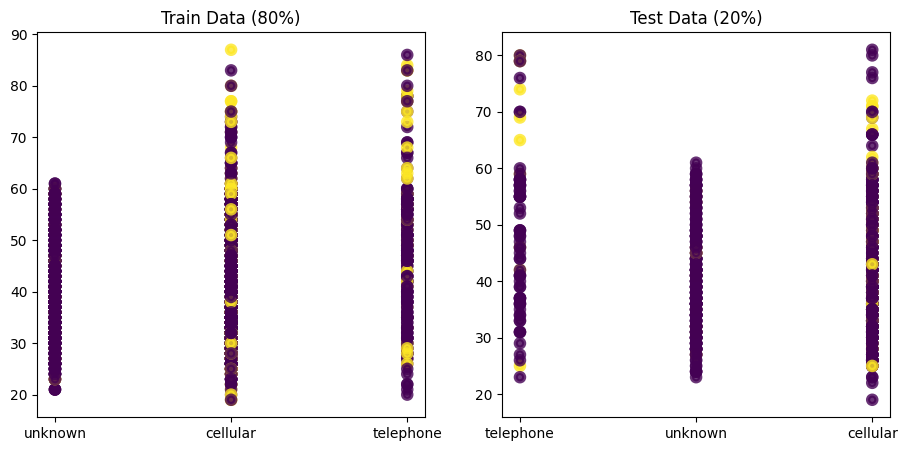

In [31]:
fig, ax=plt.subplots(1,2,figsize=(11,5), sharex=False, sharey=False)
ax1, ax3= ax
ax1.scatter(X_train.iloc[:,6],X_train.iloc[:,7], c=y_train, alpha=0.8, lw=3)
ax1.set_title('Train Data (80%)')
ax3.scatter(X_test.iloc[:,6],X_test.iloc[:,7], c=y_test, alpha=0.8, lw=3)
ax3.set_title('Test Data (20%)')
plt.show()

### Création du pipeline pour enchainer les opérations

In [73]:
def create_pipeline(model: any, X_nums, X_cats):

    # Transformer : scale les numériques et encode les catégorielles
    transformer = ColumnTransformer([
                                        ("num", StandardScaler(), X_nums),
                                        ("cat", OneHotEncoder(drop='first', handle_unknown="ignore"), 
                                         X_cats)
                                    ])

    # Build pipeline
    pipeline = Pipeline([
                            ("preprocessing", transformer),
                            ("classification", model)
                        ])

    return pipeline


### Création des Modèles

In [74]:
# Number of folds = 10 for unbalanced data
stratfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [75]:
logistic_classifier = create_pipeline(LogisticRegressionCV(class_weight = "balanced",
                                                                      cv = stratfold,
                                                                      random_state = 42),
                                                            X_nums,X_cats)
                                  
xgboost_classifier = create_pipeline(XGBClassifier(random_state = 42), 
                                     X_nums,X_cats)

adaboost_classifier = create_pipeline(AdaBoostClassifier(n_estimators=100, random_state = 42),
                                      X_nums,X_cats)
                                      

grdboost_classifier = create_pipeline(GradientBoostingClassifier(n_estimators=100, random_state = 42),
                                      X_nums,X_cats)
                                      

randomforest_classifier = create_pipeline(RandomForestClassifier(class_weight = "balanced",
                                                                 n_estimators = 150,
                                                                 random_state = 42),
                                          X_nums, X_cats)

### Entrainement

#### Fonction pour entrainer les modèles

In [76]:
def running_model(model: any, name_model: str, X:pd.DataFrame, y: pd.Series, threshold: float = 0.5):

    # Méthodes de splitting pour variable déséquilibrée
    stratfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Entraînement final du modèle
    model.fit(X, y)

    # Prédictions probabilistes
    y_prob = model.predict_proba(X_test)[:, 1]

    # seuil de probabilité pour la classification
    y_pred = (y_prob >= threshold).astype(int)


    # Classification report
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred, labels=[1,0])
    matrix=ConfusionMatrixDisplay(np.transpose(confusion), display_labels=['Yes: 1','No: 0'])


    train_size,train_score, val_score = learning_curve(model,
                                                        X, y.to_numpy().ravel(),
                                                        train_sizes=np.linspace(0.1, 1,10),
                                                        cv=stratfold,shuffle=True,random_state=0,
                                                        return_times=False)

    # Tracé des graphes 

    fig = plt.figure(figsize=(11, 9))
    gs = fig.add_gridspec(2, 2)  # 2 lignes, 2 colonnes

    ax1 = fig.add_subplot(gs[0, 0])  # ligne 0, col 0
    ax2 = fig.add_subplot(gs[0, 1])  # ligne 0, col 1
    ax3 = fig.add_subplot(gs[1, :])  # ligne 1, toutes les colonnes

    # Matrix de Confusion
    matrix.plot(cmap='Blues', ax=ax1, colorbar=False)
    ax1.text(-0.25,.9,'False Negative',c='blue')
    ax1.text(0.75,0.9,'True Negative',c='white')
    ax1.text(-.25,-.15,'True Positive', c='blue')
    ax1.text(0.75,-.15,'False Positive',c='blue')
    ax1.set_ylabel('Model predictions')
    ax1.set_xlabel('Actual Values')
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.set_title(f'Confusion Matrix for: {name_model}')

    # Courbe ROC-AUC
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('Taux de faux positifs')
    ax3.set_ylabel('Taux de vrais positifs')
    ax3.set_title(f'Courbe ROC - {name_model}')
    ax3.legend(loc="lower right")

    ax2.plot(train_size,train_score.mean(axis=1),c='b',lw=2,label='Train_score')
    ax2.plot(train_size,val_score.mean(axis=1),c='r',lw=2,label='validation_score')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Training Set Size')
    ax2.set_title(f"Train vs Validation Score: {name_model}")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return model

#### Logistic Classifier

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       801
           1       0.33      0.69      0.45       104

    accuracy                           0.81       905
   macro avg       0.64      0.76      0.67       905
weighted avg       0.88      0.81      0.83       905



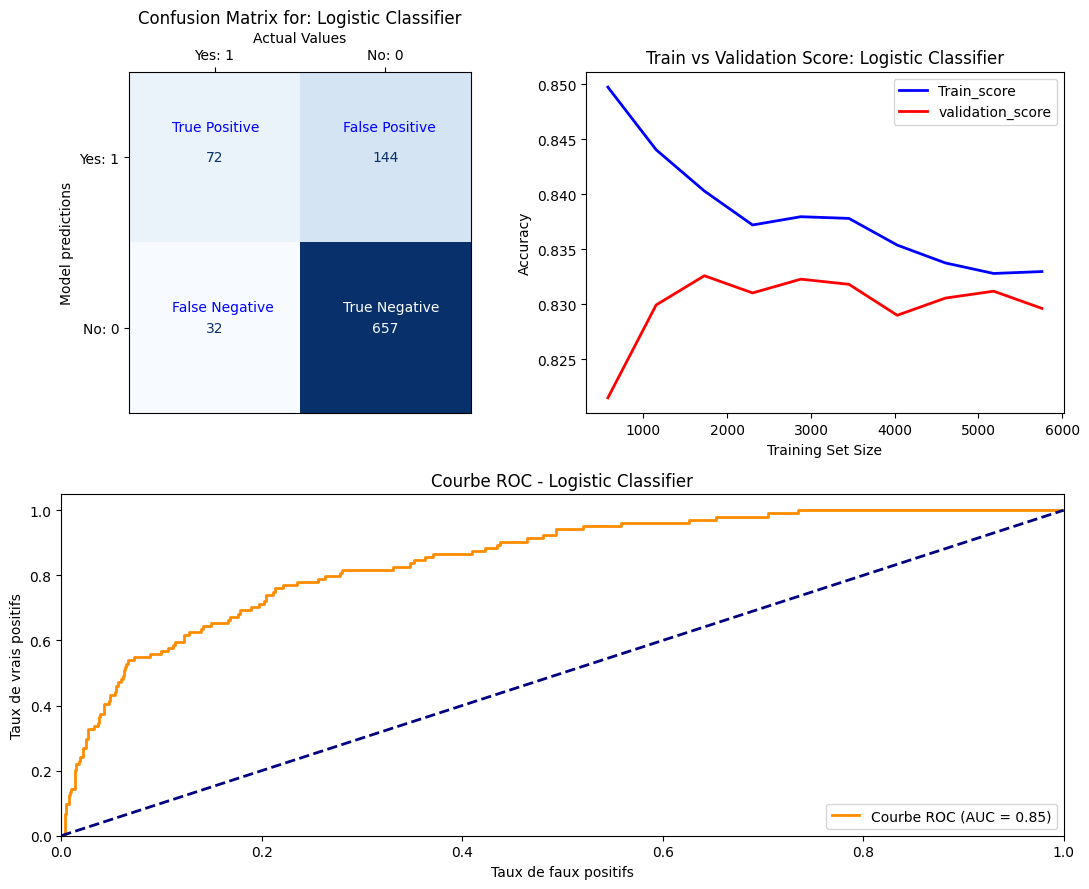

In [90]:
logistic = running_model(logistic_classifier, "Logistic Classifier",X_smote, y_smote, threshold = 0.5)

#### AdaBoostclassifier

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       801
           1       0.34      0.70      0.45       104

    accuracy                           0.81       905
   macro avg       0.65      0.76      0.67       905
weighted avg       0.88      0.81      0.83       905



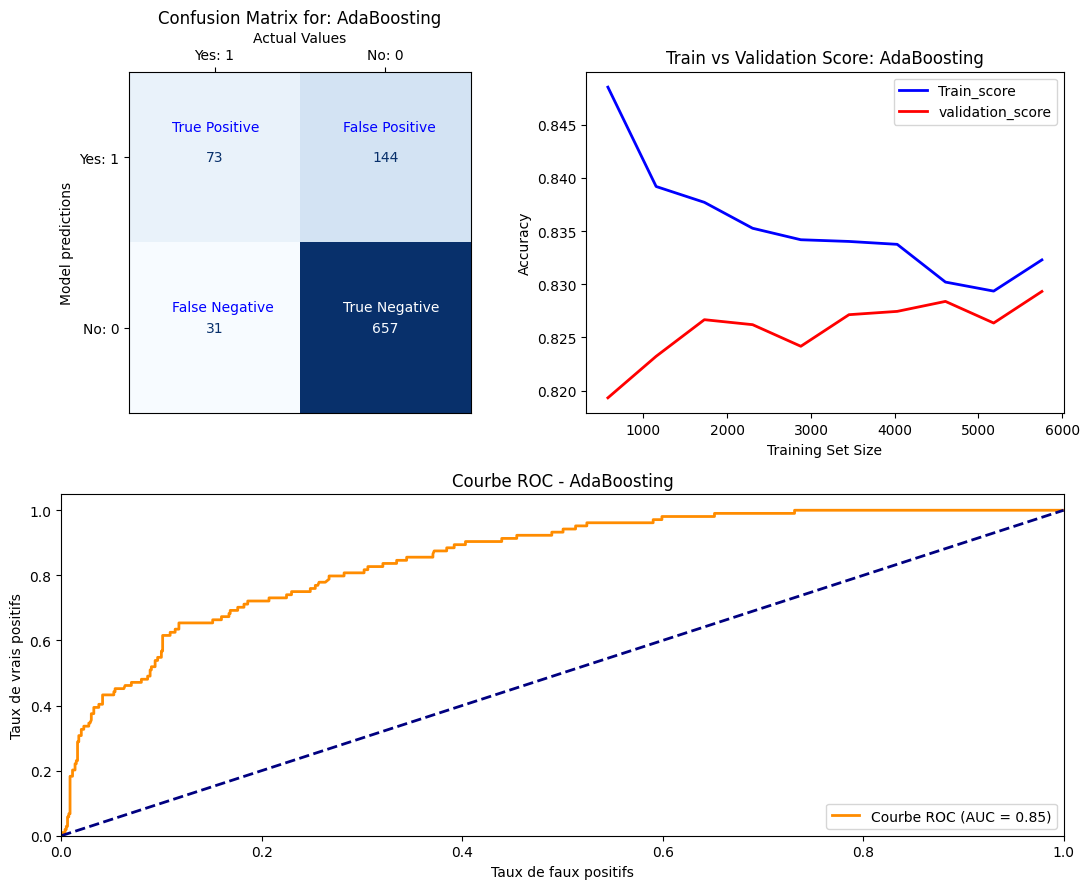

In [89]:
adaboost = running_model(adaboost_classifier, 'AdaBoosting', X_smote, y_smote, threshold = 0.5)

#### GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.95      0.85      0.89       801
           1       0.35      0.64      0.45       104

    accuracy                           0.82       905
   macro avg       0.65      0.74      0.67       905
weighted avg       0.88      0.82      0.84       905



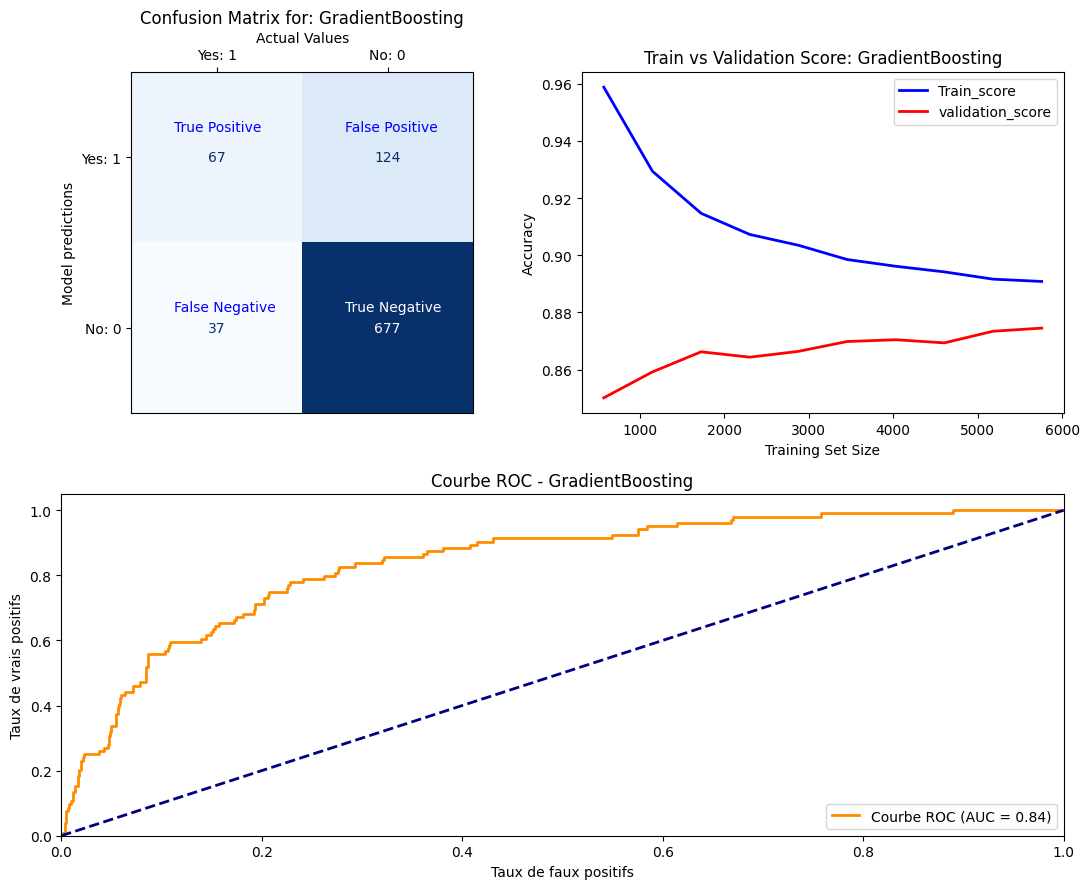

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'previous']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'poutcome',
                                                   'contact'])])),
                ('classification',
                 GradientBoostingClassifier(random_state=42))])

In [86]:
running_model(grdboost_classifier,'GradientBoosting', X_smote, y_smote, threshold = 0.5)

#### XGBoostClassifier

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       801
           1       0.44      0.56      0.49       104

    accuracy                           0.87       905
   macro avg       0.69      0.73      0.71       905
weighted avg       0.88      0.87      0.87       905



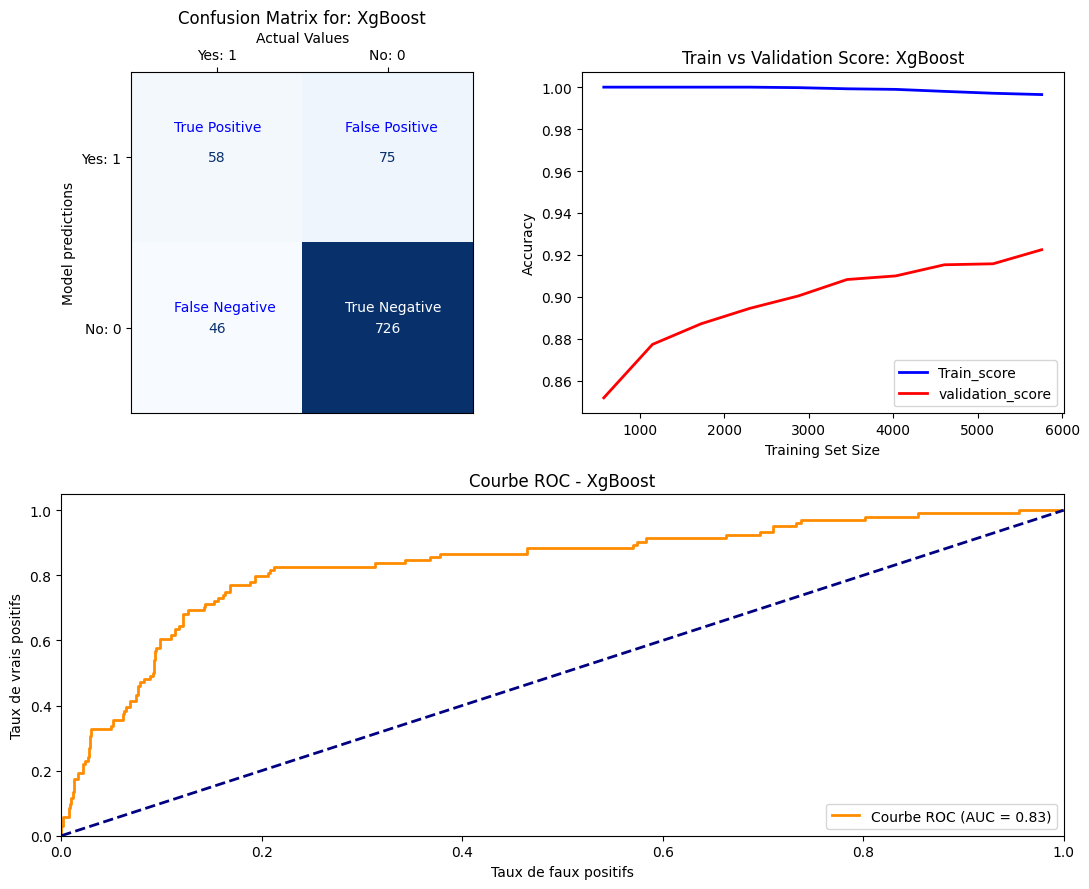

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'previous']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'poutcome',
                                                   'contact'])])),
                ('classification',
                 XGBClassifier(base_score=None, booster=None, callbacks=N...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [87]:
running_model(xgboost_classifier,'XgBoost', X_smote, y_smote, threshold=0.5)

#### Random Forest

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       801
           1       0.41      0.59      0.49       104

    accuracy                           0.86       905
   macro avg       0.68      0.74      0.70       905
weighted avg       0.88      0.86      0.87       905



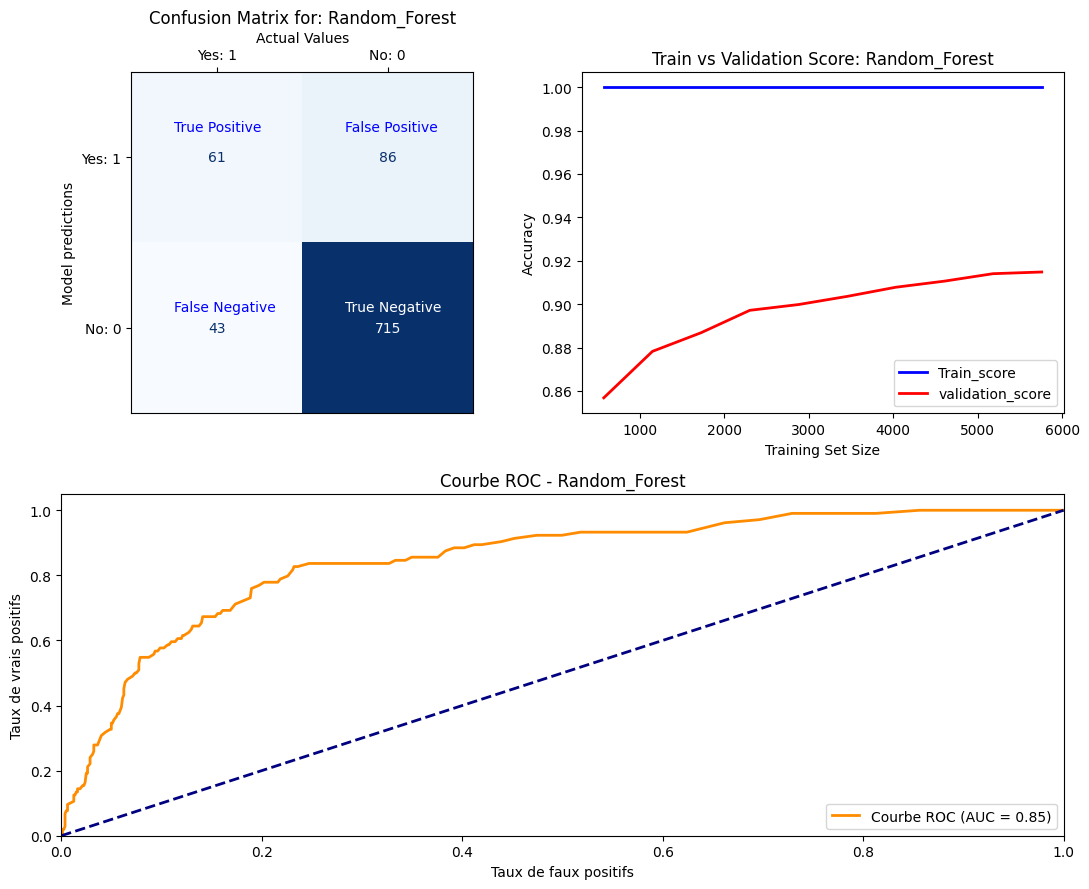

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'previous']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'poutcome',
                                                   'contact'])])),
                ('classification',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=150, random_state=42))])

In [88]:
running_model(randomforest_classifier, "Random_Forest", X_smote, y_smote, threshold = 0.5)